## Question: How does Zipf's Exponent change with sample size?

Our entire thesis is that Zipf's Law and Heap's Law are (excellent) approximations for describing text, but ultimately wrong. Let's face it, if they're wrong, it's not by much. So, if these polylogarithmic functions are correct, then what's the "apparent" Zipf exponent $\alpha(x)$, and is there a compelling derivation that matches the empirical curve?

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, LogModel

In [2]:
def zetainv(h):
    func = lambda z: zeta(z) - h
    z0 = 1.1
    z = fsolve(func, z0)[0]
    return z

def hapax(x):
    if abs(x-1) < 0.001:
        return 0.5
    return 1./np.log(x) - 1./(x-1)

### Choosing a Book

Select a book for use as our fitting corpus.

Optimum (M_z,N_z) = LogParams(M_z=176786, N_z=16010)


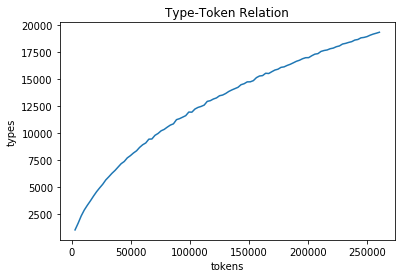

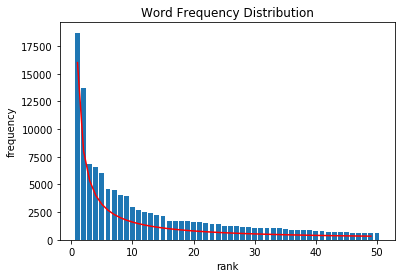

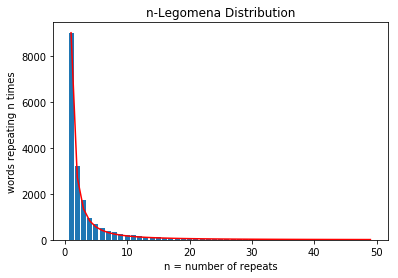

In [3]:
# moby dick
words = gutenberg.words("melville-moby_dick.txt")
corpus = Corpus(words)
corpus.dimension = 20
TTR = corpus.TTR
model = LogModel().fit(TTR.m_tokens, TTR.n_types)
print("Optimum (M_z,N_z) =", model.params)

# plot TTR curve
plt.plot(TTR.m_tokens, TTR.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# plot WFD
xmax = 50
i = np.arange(1, xmax)
df = corpus.fdist.copy().head(xmax)
plt.bar(df.index, df.freq)
plt.plot(i, model.N_z/i, color = 'r')
plt.title("Word Frequency Distribution")
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
B = zetainv(2.)
plt.bar(i, corpus.k[i])
plt.plot(i, corpus.k[1]/i**B, color = 'r')
plt.title("n-Legomena Distribution")
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.show()

x = 1
Expected hapax proportion: 0.5
Best-Fit alpha: 1.7286472389981808
Observed p_n: [0.49914991 0.14631463 0.07730773 0.04880488 0.02850285 0.02230223
 0.01850185 0.01480148]


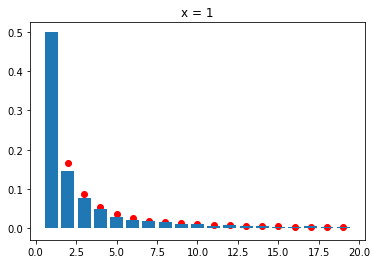

In [10]:
x = np.random.uniform(0.01, 1.99)
x = 1
print("x =", x)
h_exp = hapax(x)
print("Expected hapax proportion:", h_exp)
alpha = zetainv(1/h_exp)
print("Best-Fit alpha:", alpha)

y = np.random.zipf(alpha, 9999)
_, y = np.unique(y, return_counts = True) # group
y = y / sum(y) # normalize
p_obs = np.concatenate((np.array([0.]), y))
print("Observed p_n:", p_obs[1:9])

k_exp = model.predict_k(corpus.M * x, corpus.dimension)
p_exp = k_exp / model.predict(corpus.M * x)
k_exp = k_exp / corpus.N

L = len(p_exp)
i = np.arange(1, L)
plt.bar(i, p_obs[1:L])
plt.scatter(i, p_exp[1:L], color = 'r')
plt.title("x = " + str(x))
plt.show()

In [11]:
k = np.arange(1, 9)
s = zetainv(2.)
print(k**-s/zeta(s))
print(1./k/(k+1))

[0.5        0.15086737 0.07485067 0.04552193 0.03095262 0.02258505
 0.01730189 0.01373555]
[0.5        0.16666667 0.08333333 0.05       0.03333333 0.02380952
 0.01785714 0.01388889]


,m_tokens,n_types,lego_0,lego_1,lego_2,lego_3,lego_4,lego_5,lego_6,lego_7,...,lego_15_p_obs,lego_15_p_exp,lego_16_p_obs,lego_16_p_exp,lego_17_p_obs,lego_17_p_exp,lego_18_p_obs,lego_18_p_exp,lego_19_p_obs,lego_19_p_exp
0,2608,1041,18276,807,98,30,34,6,10,6,...,0.000961,0.000579,0.000961,0.000487,0.000961,0.000415,0.000961,0.000356,0.000000,0.000309
1,5216,1655,17662,1196,201,73,39,24,12,12,...,0.001813,0.000847,0.001208,0.000720,0.002417,0.000619,0.000604,0.000536,0.000604,0.000468
2,7824,2330,16987,1667,284,123,50,24,31,18,...,0.002146,0.001057,0.001288,0.000905,0.003004,0.000782,0.001717,0.000681,0.001717,0.000598
3,10432,2878,16439,2066,333,136,66,51,28,22,...,0.002432,0.001238,0.002432,0.001064,0.001390,0.000923,0.001042,0.000807,0.001390,0.000711
4,13040,3319,15998,2317,417,197,77,57,33,31,...,0.001205,0.001405,0.001506,0.001212,0.001205,0.001055,0.001205,0.000925,0.002109,0.000818


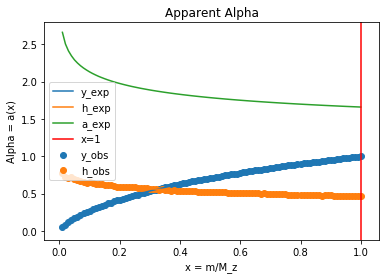

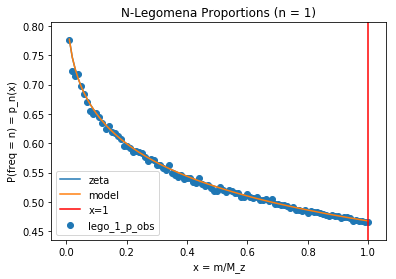

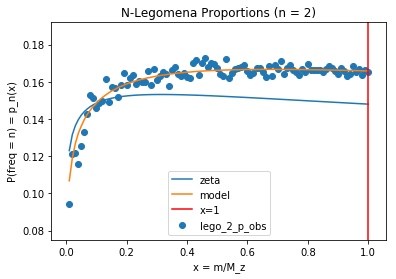

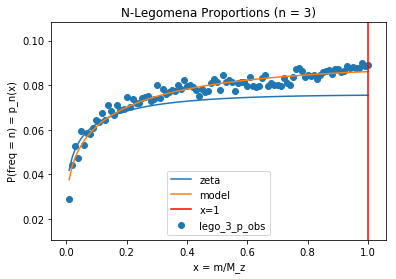

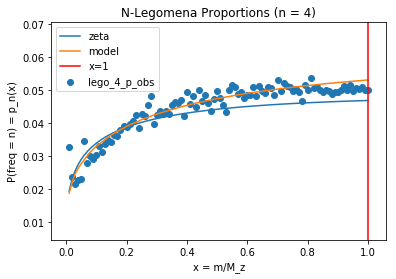

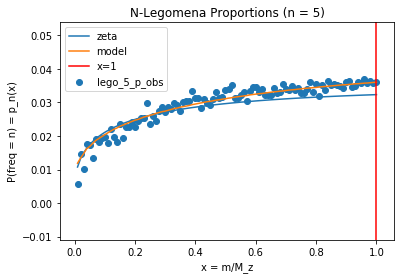

In [13]:
# calculate apparent alpha
TTR = corpus.TTR
k_x = model.predict_k(TTR.m_tokens, corpus.dimension)
E_x = model.predict(TTR.m_tokens)

# enrich TTR data
df = TTR
df["x"] = df.m_tokens / corpus.M
df["y_obs"] = df.n_types / corpus.N
df["y_exp"] = E_x / corpus.N
df["h_obs"] = df.lego_1 / df.n_types
df["h_exp"] = k_x[:,1] / E_x
df["a_exp"] = [ zetainv(1/h) for h in df["h_exp"] ]

for col in df.columns:
    if "lego_" in col:
        n = float(col.split("_")[1])
        df[col + "_p_obs"] = df[col] / df.n_types
        df[col + "_p_exp"] = df["h_exp"] / n**df["a_exp"]
        if n < 6:
            df[col + "_p_mod"] = k_x[:,int(n)] / E_x
display(df.head())

# draw a pretty plot
plt.plot(df["x"], df["y_exp"], label = "y_exp")
plt.plot(df["x"], df["h_exp"], label = "h_exp")
plt.plot(df["x"], df["a_exp"], label = "a_exp")
plt.scatter(df["x"], df["y_obs"], label = "y_obs")
plt.scatter(df["x"], df["h_obs"], label = "h_obs")
plt.axvline(x = 1, color = 'r', label = "x=1")
plt.xlabel("x = m/M_z")
plt.ylabel("Alpha = a(x)")
plt.legend()
plt.title("Apparent Alpha")
plt.show()

# draw more pretty plots
for n in range(1, 6):
    plt.scatter(df["x"], df[f"lego_{n}_p_obs"], label = f"lego_{n}_p_obs")
    plt.plot(df["x"], df[f"lego_{n}_p_exp"], label = "zeta")
    plt.plot(df["x"], df[f"lego_{n}_p_mod"], label = "model")
    plt.axvline(x = 1, color = 'r', label = "x=1")
    plt.xlabel("x = m/M_z")
    plt.ylabel("P(freq = n) = p_n(x)")
    plt.legend()
    plt.title(f"N-Legomena Proportions (n = {n})")
    plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


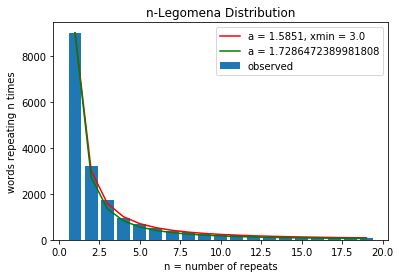

In [14]:
import powerlaw
dist = powerlaw.Fit(corpus.k[1:]).power_law
alpha, xmin = dist.alpha, dist.xmin

i = np.arange(1, 20)
B = zetainv(2.)
plt.bar(i, corpus.k[i], label = "observed")
plt.plot(i, corpus.k[1]/i**alpha, color = 'r', label = f"a = {alpha:0.4f}, xmin = {xmin}")
plt.plot(i, corpus.k[1]/i**B, color = 'g', label = f"a = {B}")
plt.title("n-Legomena Distribution")
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.legend()
plt.show()

## Conclusion

Sadly, I can't seem to square this concept. Although the $n$-legomena proportions appear to converge on a Zeta Distribution in the limit, taking this idea literally does not appear to bear fruit. Look no further than the dis legomena prediction at $x=1$. Our model predicts $p_2(1) = 1/6 \approx 0.1667$ which is far closer to empirical observations than a Zeta Distribution, in which $p_2(1) = p_1(1) / 2^{\zeta^{-1}(1/p_1(1))} \approx 0.5/2^{1.72864723899818} \approx 0.15086737$.

Having said that, the curves really do _look_ and _behave_ somewhat the same, even though they clearly aren't _equal_. So it's conceivable there is some deeper connection between the two or some conversion factor buried in the math linking the polylogarithms to a simple exponent. Seems like an outside chance, but it can't be ruled out that some modification to a Zeta Distribution may fit the data.